# Optimisation de la fonction de coût du modèle XGBoost

In [1]:
import sys
sys.path.insert(0, "/home/cyril/openclassrooms/projets/P7/P7_baudrillart_cyril_V2/custom_functions")
from model_analysis import plot_confusion_matrix, plot_roc_curve

In [2]:
# Import basic ML libraries
import pandas as pd
import numpy as np
from collections import Counter
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
# Scikit-Learn imports
from sklearn.model_selection import (RepeatedStratifiedKFold, cross_validate,
                                     StratifiedKFold, train_test_split,
                                     KFold)
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import (f1_score, recall_score, roc_auc_score, 
                            precision_score, r2_score, accuracy_score, auc)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

# other ML libraries
from imblearn.pipeline import Pipeline, make_pipeline
from xgboost import XGBClassifier

# Chargement du jeu de données

In [4]:
# Chargement des données intégrales imputées
X = pd.read_csv('../data_models/X_top10_imputed.csv', index_col=0)

In [5]:
# Création de la target
y = X.TARGET
y

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
292057    1.0
292058    1.0
292059    1.0
292060    1.0
292061    1.0
Name: TARGET, Length: 292062, dtype: float64

In [6]:
# Supprimer la target des features
X = X.drop(columns='TARGET')

In [7]:
# Comptage des classes
Counter(y)

Counter({0.0: 268139, 1.0: 23923})

In [8]:
# train-test split with stratification on the class we are trying to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [9]:
# Nombre d'observations dans chaque classe du test set
Counter(y_test)

Counter({0.0: 80442, 1.0: 7177})

In [10]:
# Rapport entre les classes
Counter(y_test)[0]/Counter(y_test)[1]

11.208304305420093

# Modèle XGBoost

In [70]:
# Rééquilibrage des classes par under sampling et modèle xgboost
steps = [('oversample', RandomUnderSampler(random_state=42)),
         ('model', XGBClassifier())]
# création d'un pipeline imblearn
pipeline = Pipeline(steps=steps)

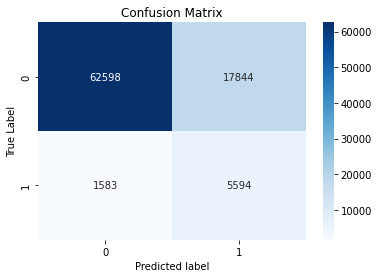

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.24      0.78      0.37      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.78      0.62     87619
weighted avg       0.91      0.78      0.82     87619

ROC AUC Score: 0.78
CPU times: user 30.1 s, sys: 233 ms, total: 30.4 s
Wall time: 2.4 s


In [71]:
%%time
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

# Mise en place d'une fonction de coût métier

La première étape indiquée dans le notebook 9 était de maximiser le recall, c'est à dire de minimiser le taux de faux négatifs. Afin d'améliorer la fonction de coût, il faut également chercher à minimiser le taux de faux positifs. On va créer une fonction de coût qui pénalise plus les faux négatifs (coefficient 11 correspondant au ratio classe majoritaire/ classe minoritaire) que les faux positifs (coefficient 1). Les bonnes prédictions ne sont pas pénalisées. Voir note méthodologique N°2.

Le problème est très bien expliqué ici: https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/

## Score sur mesure pénalisant les faux négatifs

In [74]:
# Affichage de la matrice de confusion du modèle précédent
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[62598, 17844],
       [ 1583,  5594]])

In [75]:
# Nombre total d'échantillons
cf_matrix.sum()

87619

In [77]:
def credit_score(y_test, y_pred):
    """
    Calcul score crédit sur mesure
    ( 11 x Faux négatifs + Faux positif) / nombre d'observations
    """
    # calcul matric de confusion
    cf_matrix = confusion_matrix(y_test, y_pred)
    # Nombre de faux positifs 
    FP = cf_matrix[0][1]
    # Nombre de faux négatifs 
    FN = cf_matrix[1][0]
    # Nombre total d'observations
    total = cf_matrix.sum()
    
    # Calcul du score
    eval_score = (11*FN + FP) / total
    
    return eval_score

In [78]:
# création du score pour le GridSearch (objectif = minimiser ce score)
credit_scorer = make_scorer(custom_score, greater_is_better=False)

In [ ]:
# paramètres à optimiser
param = {
        'model__n_estimators': range(50, 350, 50),
        'model__learning_rate': np.linspace(start = 0.1, stop = 0.8, num = 10)
}

In [79]:
# Paramètrage de l'optimisation GridSearch
gsearch = GridSearchCV(estimator = pipeline,
                        param_grid = param,
                        scoring=credit_scorer,
                        n_jobs=-1,
                        verbose=3,
                        cv=cv)

In [80]:
gsearch.fit(X_train.values, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('oversample',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      callbacks=None,
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,...
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0,
                                                      reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': array([0.1       , 0.17777778, 0.25555556, 0.33333333, 0.41111111,
       0.48888889, 0.56666667, 0.64444444, 0.72222222, 0.8       ]),
                         'model__n_estimators': range(50, 350, 50)},
             scoring=make_scorer(custom_score, greater_is_better=False),
             verbose=3)

In [81]:
# paramètres optimaux sélectionnés
gsearch.best_params_

{'model__learning_rate': 0.1, 'model__n_estimators': 100}

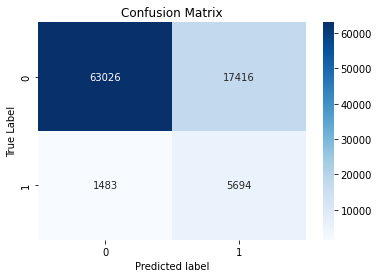

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.25      0.79      0.38      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.79      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.79
CPU times: user 1.49 s, sys: 1.57 s, total: 3.05 s
Wall time: 476 ms


In [82]:
%%time
y_pred = gsearch.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [83]:
# Valeur du score crédit dans le modèle optimisé
custom_score(y_test, y_pred)

0.38495075269062645

[CV 1/3] END model__learning_rate=0.1, model__n_estimators=250;, score=-0.398 total time=  20.6s
[CV 2/3] END model__learning_rate=0.17777777777777778, model__n_estimators=300;, score=-0.418 total time=  23.6s
[CV 2/3] END model__learning_rate=0.33333333333333337, model__n_estimators=150;, score=-0.426 total time=  12.3s
[CV 3/3] END model__learning_rate=0.4111111111111111, model__n_estimators=50;, score=-0.411 total time=   4.1s
[CV 3/3] END model__learning_rate=0.4111111111111111, model__n_estimators=150;, score=-0.430 total time=  11.7s
[CV 3/3] END model__learning_rate=0.48888888888888893, model__n_estimators=50;, score=-0.417 total time=   4.2s
[CV 1/3] END model__learning_rate=0.48888888888888893, model__n_estimators=200;, score=-0.435 total time=  16.4s
[CV 2/3] END model__learning_rate=0.5666666666666667, model__n_estimators=200;, score=-0.438 total time=  15.8s
[CV 1/3] END model__learning_rate=0.6444444444444445, model__n_estimators=250;, score=-0.443 total time=  20.5s
[CV 3

[CV 3/3] END model__learning_rate=0.1, model__n_estimators=50;, score=-0.391 total time=   4.5s
[CV 1/3] END model__learning_rate=0.17777777777777778, model__n_estimators=50;, score=-0.394 total time=   4.9s
[CV 2/3] END model__learning_rate=0.17777777777777778, model__n_estimators=100;, score=-0.403 total time=   9.7s
[CV 3/3] END model__learning_rate=0.17777777777777778, model__n_estimators=250;, score=-0.404 total time=  19.8s
[CV 1/3] END model__learning_rate=0.33333333333333337, model__n_estimators=50;, score=-0.405 total time=   4.6s
[CV 3/3] END model__learning_rate=0.33333333333333337, model__n_estimators=100;, score=-0.413 total time=   8.6s
[CV 1/3] END model__learning_rate=0.33333333333333337, model__n_estimators=300;, score=-0.430 total time=  23.8s
[CV 1/3] END model__learning_rate=0.48888888888888893, model__n_estimators=150;, score=-0.436 total time=  12.3s
[CV 2/3] END model__learning_rate=0.5666666666666667, model__n_estimators=50;, score=-0.421 total time=   4.2s
[CV 

[CV 1/3] END model__learning_rate=0.1, model__n_estimators=100;, score=-0.394 total time=   8.5s
[CV 2/3] END model__learning_rate=0.17777777777777778, model__n_estimators=50;, score=-0.399 total time=   4.6s
[CV 1/3] END model__learning_rate=0.17777777777777778, model__n_estimators=150;, score=-0.403 total time=  12.5s
[CV 3/3] END model__learning_rate=0.25555555555555554, model__n_estimators=50;, score=-0.394 total time=   4.3s
[CV 3/3] END model__learning_rate=0.25555555555555554, model__n_estimators=150;, score=-0.413 total time=  12.0s
[CV 1/3] END model__learning_rate=0.33333333333333337, model__n_estimators=100;, score=-0.411 total time=   8.7s
[CV 2/3] END model__learning_rate=0.33333333333333337, model__n_estimators=250;, score=-0.431 total time=  20.0s
[CV 3/3] END model__learning_rate=0.4111111111111111, model__n_estimators=300;, score=-0.433 total time=  25.0s
[CV 1/3] END model__learning_rate=0.5666666666666667, model__n_estimators=250;, score=-0.432 total time=  19.5s
[CV

## Option: utilisation du F Beta score

Pour optimiser le recall et la précision de anière simultanée, on peut aussi utiliser le F Beta score. Il faut définir un paramètre Beta qui est le coefficient d'importance relative du recall par rapport à la précision. On peut le fixer à 10 par défaut, ce qui correpond au ratio entre les classes majoritaires et minoritaires (voir article ci-dessus pour plus de détails). Il faut chercher à maximiser cette mesure.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

Voir doc fonction make_scorer:  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html

In [84]:
from sklearn.metrics import fbeta_score, make_scorer
f_beta_scorer = make_scorer(fbeta_score, beta=11)

In [85]:
# On reprned les mêmes paramètres que précédemment
param = {
        'model__n_estimators': range(50, 350, 50),
        'model__learning_rate': np.linspace(start = 0.1, stop = 0.8, num = 10)
}

In [86]:
# utilisation de la cross validation
cv = StratifiedKFold(n_splits=3)

In [87]:
gsearch = GridSearchCV(estimator = pipeline,
                        param_grid = param,
                        scoring=f_beta_scorer,
                        n_jobs=-1,
                        verbose=3,
                        cv=cv)

In [88]:
gsearch.fit(X_train.values, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('oversample',
                                        RandomUnderSampler(random_state=42)),
                                       ('model',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      callbacks=None,
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,...
                                                      n_estimators=100,
                                                      n_jobs=0,
                                                      num_parallel_tree=1,
                                                      predictor='auto',
                                                      random_state=0,
                                                      reg_alpha=0, reg_lambda=1, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': array([0.1       , 0.17777778, 0.25555556, 0.33333333, 0.41111111,
       0.48888889, 0.56666667, 0.64444444, 0.72222222, 0.8       ]),
                         'model__n_estimators': range(50, 350, 50)},
             scoring=make_scorer(fbeta_score, beta=11), verbose=3)

In [89]:
gsearch.best_params_

{'model__learning_rate': 0.17777777777777778, 'model__n_estimators': 50}

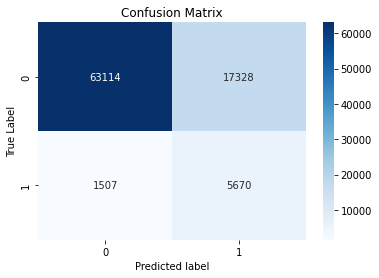

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.25      0.79      0.38      7177

    accuracy                           0.79     87619
   macro avg       0.61      0.79      0.62     87619
weighted avg       0.92      0.79      0.83     87619

ROC AUC Score: 0.79
CPU times: user 1.33 s, sys: 1.46 s, total: 2.79 s
Wall time: 421 ms
[CV 1/3] END model__learning_rate=0.1, model__n_estimators=100;, score=0.768 total time=   8.7s
[CV 3/3] END model__learning_rate=0.17777777777777778, model__n_estimators=50;, score=0.768 total time=   4.8s
[CV 1/3] END model__learning_rate=0.17777777777777778, model__n_estimators=200;, score=0.760 total time=  18.1s
[CV 2/3] END model__learning_rate=0.25555555555555554, model__n_estimators=200;, score=0.761 total time=  15.5s
[CV 3/3] END model__learning_rate=0.33333333333333337, model__n_estimators=200;, score=0.754 total time=  17.2s
[CV 1/3] END model__learning_rate=0.41111

[CV 2/3] END model__learning_rate=0.1, model__n_estimators=250;, score=0.766 total time=  21.2s
[CV 1/3] END model__learning_rate=0.25555555555555554, model__n_estimators=50;, score=0.768 total time=   4.7s
[CV 3/3] END model__learning_rate=0.25555555555555554, model__n_estimators=100;, score=0.762 total time=   8.5s
[CV 1/3] END model__learning_rate=0.25555555555555554, model__n_estimators=300;, score=0.759 total time=  23.2s
[CV 2/3] END model__learning_rate=0.4111111111111111, model__n_estimators=100;, score=0.762 total time=   8.6s
[CV 2/3] END model__learning_rate=0.4111111111111111, model__n_estimators=250;, score=0.748 total time=  19.7s
[CV 3/3] END model__learning_rate=0.48888888888888893, model__n_estimators=300;, score=0.749 total time=  23.9s
[CV 1/3] END model__learning_rate=0.6444444444444445, model__n_estimators=200;, score=0.748 total time=  16.9s
[CV 3/3] END model__learning_rate=0.7222222222222222, model__n_estimators=200;, score=0.733 total time=  15.4s
[CV 2/3] END 

[CV 3/3] END model__learning_rate=0.1, model__n_estimators=100;, score=0.767 total time=   9.7s
[CV 2/3] END model__learning_rate=0.17777777777777778, model__n_estimators=100;, score=0.767 total time=   8.9s
[CV 2/3] END model__learning_rate=0.17777777777777778, model__n_estimators=250;, score=0.761 total time=  19.7s
[CV 3/3] END model__learning_rate=0.25555555555555554, model__n_estimators=300;, score=0.759 total time=  23.3s
[CV 2/3] END model__learning_rate=0.4111111111111111, model__n_estimators=200;, score=0.751 total time=  16.5s
[CV 3/3] END model__learning_rate=0.48888888888888893, model__n_estimators=200;, score=0.752 total time=  16.2s
[CV 1/3] END model__learning_rate=0.5666666666666667, model__n_estimators=250;, score=0.754 total time=  21.8s
[CV 3/3] END model__learning_rate=0.6444444444444445, model__n_estimators=250;, score=0.742 total time=  20.4s
[CV 2/3] END model__learning_rate=0.8, model__n_estimators=50;, score=0.746 total time=   4.0s
[CV 3/3] END model__learning

In [90]:
%%time
y_pred = gsearch.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [91]:
# Valeur du score crédit dans le modèle optimisé
custom_score(y_test, y_pred)

0.3869594494344834

On voit que cette optimisation de la fonction de coût a permi de réduire à la fois le nombre de faux négatifs et de faux positifs, tout en améliorant légèrement le recall et le score F1.